
# General setup


In [1]:
!python -m pip install --quiet git+https://github.com/carnotresearch/cr-vision.git


     |████████████████████████████████| 2.3MB 7.4MB/s 
     |████████████████████████████████| 204kB 37.0MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 9.2MB 33.5MB/s 
     |████████████████████████████████| 2.8MB 58.0MB/s 
     |████████████████████████████████| 563kB 38.9MB/s 
     |████████████████████████████████| 122kB 62.2MB/s 
     |████████████████████████████████| 92kB 13.2MB/s 
     |████████████████████████████████| 92kB 14.0MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
ERROR: sphinx 3.5.4 has requirement docutils<0.17,>=0.12, but you'll have docutils 0.17 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: sphinx-rtd-theme 0.5.2 has requirement docutils<0.17, but you'll have docutils 0.17 which is incompatible.


Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy and unzip test images

In [3]:
!cp  /content/drive/MyDrive/datasets/birds/birds_subset_5000/test.zip .

In [4]:
!unzip -q test.zip

Copy  driver code for the experiment setup

In [5]:
!cp /content/drive/MyDrive/work/cr-vision/experiments/cs/csresnet/csresnet.py .


Import essential packages

In [6]:
from pathlib import Path
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

Import utilities from CR-Vision package

In [7]:

from cr.vision.io import images_from_dir

Import driver module for the experiment

In [8]:
import csresnet

# Test images

In [9]:
rootdir = Path('test')

Load some test images along with their paths

In [10]:
images, image_paths = images_from_dir(rootdir, size=12, include_paths=True)

Compute names of these images

In [11]:
names = [path.name for path in image_paths]

In [12]:
images.shape

(12, 256, 256, 3)

# Trained model

Load trained model based on parameters on which model name was assigned 

In [13]:
patch_size = 24
stride_size = 16
compression_ratio = 64
num_res_blocks=2
num_res_channels=32
input_shape  = (256, 256, 3)

In [14]:
model_name = csresnet.form_model_name('autoencoder', patch_size, stride_size, num_res_blocks, num_res_channels, compression_ratio)
model = csresnet.load_saved_model(model_name)
model.summary()

Loading the saved model from /content/drive/MyDrive/work/cr-vision/experiments/cs/csresnet/saved_model_autoencoder_p=24_s=16_b=2_c=32_cr=64
Model: "CSResNet_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
CSResNet_Encoder (Functional (None, 16, 16, 12)        20748     
_________________________________________________________________
CSResNet_Decoder (Functional (None, 256, 256, 3)       240579    
Total params: 261,327
Trainable params: 261,327
Non-trainable params: 0
_________________________________________________________________


# Reconstruction of test images

In [15]:
reconstructions = model.predict(images)


# PSNR calculations

In [16]:
n = images.shape[0]
psnr_values = []

for i in range(n):
    name = names[i]
    src = images[i]
    dst = reconstructions[i]
    psnr = peak_signal_noise_ratio(src, dst)
    psnr_values.append(psnr)
    print(f"[{i+1}] PSNR : {psnr:.2f} dB, Image={name} ")


[1] PSNR : 23.70 dB, Image=081.Pied_Kingfisher_Pied_Kingfisher_0051_71429.jpg 
[2] PSNR : 25.46 dB, Image=160.Black_throated_Blue_Warbler_Black_Throated_Blue_Warbler_0083_161462.jpg 
[3] PSNR : 22.66 dB, Image=090.Red_breasted_Merganser_Red_Breasted_Merganser_0033_79353.jpg 
[4] PSNR : 16.80 dB, Image=117.Clay_colored_Sparrow_Clay_Colored_Sparrow_0041_110726.jpg 
[5] PSNR : 23.10 dB, Image=023.Brandt_Cormorant_Brandt_Cormorant_0062_23038.jpg 
[6] PSNR : 22.97 dB, Image=056.Pine_Grosbeak_Pine_Grosbeak_0014_38398.jpg 
[7] PSNR : 21.30 dB, Image=027.Shiny_Cowbird_Shiny_Cowbird_0055_24331.jpg 
[8] PSNR : 23.34 dB, Image=056.Pine_Grosbeak_Pine_Grosbeak_0036_38968.jpg 
[9] PSNR : 24.72 dB, Image=158.Bay_breasted_Warbler_Bay_Breasted_Warbler_0060_159863.jpg 
[10] PSNR : 20.21 dB, Image=036.Northern_Flicker_Northern_Flicker_0079_28630.jpg 
[11] PSNR : 26.32 dB, Image=083.White_breasted_Kingfisher_White_Breasted_Kingfisher_0088_73386.jpg 
[12] PSNR : 26.92 dB, Image=073.Blue_Jay_Blue_Jay_0044_6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


In [17]:
psnr_values = np.array(psnr_values)

In [18]:
pmax = psnr_values.max()
pmin = psnr_values.min()
pmean = psnr_values.mean()
pstd = psnr_values.std()
percentiles = np.percentile(psnr_values, [25, 50, 75])
stats = {'max': pmax, 'min': pmin, 'mean': pmean, 'std': pstd, 'median': percentiles[1], 'iqr': percentiles[2] - percentiles[0], 'q1' : percentiles[0], 'q3': percentiles[2]}
for k, v in stats.items():
  print(f'{k}: {v:.2f} dB')

max: 26.92 dB
min: 16.80 dB
mean: 23.13 dB
std: 2.66 dB
median: 23.22 dB
iqr: 2.59 dB
q1: 22.32 dB
q3: 24.91 dB


In [19]:
n = images.shape[0]

for i in range(n):
    name = names[i]
    name = name[:-4]
    parts = name.split('_')
    parts = [part for part in parts if not part.isdigit()]
    name = (" ").join(parts)
    src = images[i]
    dst = reconstructions[i]
    psnr = peak_signal_noise_ratio(src, dst)
    print(f"  * - {name}")
    print(f"    - {psnr:0.2f}")

  * - 081.Pied Kingfisher Pied Kingfisher
    - 23.70
  * - 160.Black throated Blue Warbler Black Throated Blue Warbler
    - 25.46
  * - 090.Red breasted Merganser Red Breasted Merganser
    - 22.66
  * - 117.Clay colored Sparrow Clay Colored Sparrow
    - 16.80
  * - 023.Brandt Cormorant Brandt Cormorant
    - 23.10
  * - 056.Pine Grosbeak Pine Grosbeak
    - 22.97
  * - 027.Shiny Cowbird Shiny Cowbird
    - 21.30
  * - 056.Pine Grosbeak Pine Grosbeak
    - 23.34
  * - 158.Bay breasted Warbler Bay Breasted Warbler
    - 24.72
  * - 036.Northern Flicker Northern Flicker
    - 20.21
  * - 083.White breasted Kingfisher White Breasted Kingfisher
    - 26.32
  * - 073.Blue Jay Blue Jay
    - 26.92


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  # This is added back by InteractiveShellApp.init_path()


# Visualizations

In [20]:
from cr.vision.plots import plot_images_with_reconstructions


In [25]:
num_images_to_plot = 12

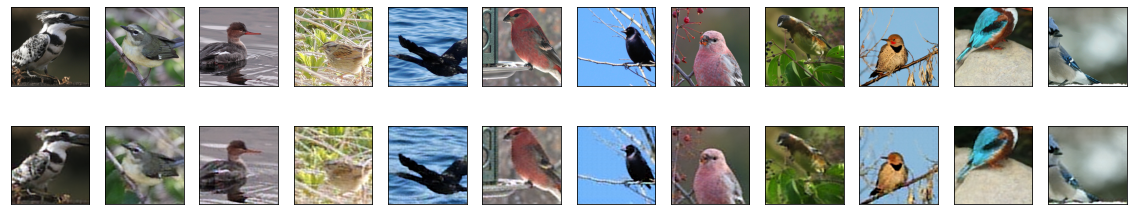

In [26]:
plot_images_with_reconstructions(images[:num_images_to_plot], reconstructions[:num_images_to_plot])
